# Лабораторная работа 4

Бизнес цели:
1. Оптимизация ценовой стратегии: анализ факторов, влияющих на стоимость недвижимости, чтобы помочь продавцам устанавливать конкурентоспособные цены и увеличивать прибыль.
2. Улучшение инвестиционных решений: предоставление аналитики для инвесторов, чтобы они могли определить наиболее выгодные районы и типы недвижимости для вложений.

#### Загрузка набора данных

In [26]:
import pandas as pd

from sklearn import set_config

set_config(transform_output="pandas")

random_state = 42

df = pd.read_csv("data/kc_house_data.csv", index_col="id")

df["date"] = pd.to_datetime(df["date"])
df["date_numeric"] = (df["date"] - pd.Timestamp("1970-01-01")).dt.days
df = df.drop(columns=["date"])

average_price = df['price'].mean()

print(f"Среднее значение поля 'цена': {average_price}")

average_price = df["price"].mean()
df['above_average_price'] = (df['price'] > average_price).astype(int)

df

Среднее значение поля 'цена': 540088.1417665294


price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
id                                                                         
7129300520  221900.0         3       1.00         1180      5650     1.0   
6414100192  538000.0         3       2.25         2570      7242     2.0   
5631500400  180000.0         2       1.00          770     10000     1.0   
2487200875  604000.0         4       3.00         1960      5000     1.0   
1954400510  510000.0         3       2.00         1680      8080     1.0   
...              ...       ...        ...          ...       ...     ...   
263000018   360000.0         3       2.50         1530      1131     3.0   
6600060120  400000.0         4       2.50         2310      5813     2.0   
1523300141  402101.0         2       0.75         1020      1350     2.0   
291310100   400000.0         3       2.50         1600      2388     2.0   
1523300157  325000.0         2       0.75         1020      1076     2.0   

            waterfront  view  condition  grade  ...  sqft_basement  yr_built  \
id                                              ...                            
7129300520           0     0          3      7  ...              0      1955   
6414100192           0     0          3      7  ...            400      1951   
5631500400           0     0          3      6  ...              0      1933   
2487200875           0     0          5      7  ...            910      1965   
1954400510           0     0          3      8  ...              0      1987   
...                ...   ...        ...    ...  ...            ...       ...   
263000018            0     0          3      8  ...              0      2009   
6600060120           0     0          3      8  ...              0      2014   
1523300141           0     0          3      7  ...              0      2009   
291310100            0     0          3      8  ...              0      2004   
1523300157           0     0          3      7  ...              0      2008   

            yr_renovated  zipcode      lat     long  sqft_living15  \
id                                                                   
7129300520             0    98178  47.5112 -122.257           1340   
6414100192          1991    98125  47.7210 -122.319           1690   
5631500400             0    98028  47.7379 -122.233           2720   
2487200875             0    98136  47.5208 -122.393           1360   
1954400510             0    98074  47.6168 -122.045           1800   
...                  ...      ...      ...      ...            ...   
263000018              0    98103  47.6993 -122.346           1530   
6600060120             0    98146  47.5107 -122.362           1830   
1523300141             0    98144  47.5944 -122.299           1020   
291310100              0    98027  47.5345 -122.069           1410   
1523300157             0    98144  47.5941 -122.299           1020   

            sqft_lot15  date_numeric  above_average_price  
id                                                         
7129300520        5650         16356                    0  
6414100192        7639         16413                    0  
5631500400        8062         16491                    0  
2487200875        5000         16413                    1  
1954400510        7503         16484                    0  
...                ...           ...                  ...  
263000018         1509         16211                    0  
6600060120        7200         16489                    0  
1523300141        2007         16244                    0  
291310100         1287         16451                    0  
1523300157        1357         16358                    0  

[21613 rows x 21 columns]

#### Разделение набора данных на обучающую и тестовые выборки (80/20) для задачи классификации

In [ ]:
from typing import Tuple
import pandas as pd
from pandas import DataFrame
from sklearn.model_selection import train_test_split

def split_stratified_into_train_val_test(
    df_input,
    stratify_colname="y",
    frac_train=0.6,
    frac_val=0.15,
    frac_test=0.25,
    random_state=None,
) -> Tuple[DataFrame, DataFrame, DataFrame, DataFrame, DataFrame, DataFrame]:
    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError(
            "fractions %f, %f, %f do not add up to 1.0"
            % (frac_train, frac_val, frac_test)
        )
    if stratify_colname not in df_input.columns:
        raise ValueError("%s is not a column in the dataframe" % (stratify_colname))
    X = df_input  
    y = df_input[
        [stratify_colname]
    ]  
    
    df_train, df_temp, y_train, y_temp = train_test_split(
        X, y, stratify=y, test_size=(1.0 - frac_train), random_state=random_state
    )
    if frac_val <= 0:
        assert len(df_input) == len(df_train) + len(df_temp)
        return df_train, pd.DataFrame(), df_temp, y_train, pd.DataFrame(), y_temp
    
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(
        df_temp,
        y_temp,
        stratify=y_temp,
        test_size=relative_frac_test,
        random_state=random_state,
    )
    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)
    return df_train, df_val, df_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = split_stratified_into_train_val_test(
    df,
    stratify_colname="above_average_price",
    frac_train=0.80,
    frac_val=0,
    frac_test=0.20,
    random_state=random_state,
)

display("X_train", X_train)
display("y_train", y_train)

display("X_test", X_test)
display("y_test", y_test)

'X_train'

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
id                                                                         
5205000020  360000.0         4       2.50         2610      7333     2.0   
4221270290  544900.0         3       2.50         1990      4936     2.0   
3438501327  352500.0         2       2.50         1570      2399     2.0   
2726079098  560000.0         3       2.50         2840    216493     2.0   
5072200040  403000.0         3       2.00         1960     13100     1.0   
...              ...       ...        ...          ...       ...     ...   
5104531120  775000.0         5       2.75         3750     12077     2.0   
2685600090  345000.0         3       1.50         1030      6969     1.0   
9528104985  611000.0         2       1.00         1270      5100     1.0   
3450300430  317500.0         4       1.50         1730      7700     1.0   
3956900480  779000.0         3       1.75         1990      5600     1.0   

            waterfront  view  condition  grade  ...  sqft_basement  yr_built  \
id                                              ...                            
5205000020           0     0          3      8  ...              0      1988   
4221270290           0     0          3      8  ...              0      2004   
3438501327           0     0          3      7  ...            390      2009   
2726079098           0     0          3      9  ...              0      1991   
5072200040           0     2          5      8  ...            310      1957   
...                ...   ...        ...    ...  ...            ...       ...   
5104531120           0     4          3     10  ...              0      2005   
2685600090           0     0          4      6  ...              0      1921   
9528104985           0     0          3      7  ...            170      1900   
3450300430           0     0          4      7  ...            720      1963   
3956900480           0     1          3      8  ...            660      1941   

            yr_renovated  zipcode      lat     long  sqft_living15  \
id                                                                   
5205000020             0    98003  47.2721 -122.293           2280   
4221270290             0    98075  47.5911 -122.018           2250   
3438501327             0    98106  47.5488 -122.364           1590   
2726079098             0    98014  47.7020 -121.892           2820   
5072200040             0    98166  47.4419 -122.340           1960   
...                  ...      ...      ...      ...            ...   
5104531120             0    98038  47.3525 -122.002           3120   
2685600090             0    98108  47.5492 -122.300           1420   
9528104985             0    98115  47.6771 -122.328           1670   
3450300430             0    98059  47.4996 -122.163           1650   
3956900480             0    98199  47.6500 -122.415           2630   

            sqft_lot15  date_numeric  above_average_price  
id                                                         
5205000020        9033         16534                    0  
4221270290        4815         16395                    1  
3438501327        2306         16559                    0  
2726079098      175111         16331                    1  
5072200040       10518         16192                    0  
...                ...           ...                  ...  
5104531120        7255         16517                    1  
2685600090        6000         16392                    0  
9528104985        3900         16378                    1  
3450300430        8066         16440                    0  
3956900480        6780         16316                    1  

[17290 rows x 21 columns]

'y_train'

above_average_price
id                             
5205000020                    0
4221270290                    1
3438501327                    0
2726079098                    1
5072200040                    0
...                         ...
5104531120                    1
2685600090                    0
9528104985                    1
3450300430                    0
3956900480                    1

[17290 rows x 1 columns]

'X_test'

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
id                                                                         
9421500010  442500.0         4       2.25         1970      7902     1.0   
3204800200  665000.0         4       2.75         3320     10574     2.0   
3320000212  397500.0         3       2.25         1350       980     2.0   
9206950100  343000.0         3       2.50         1270      2509     2.0   
3121069038  355000.0         3       2.50         2620     78843     1.0   
...              ...       ...        ...          ...       ...     ...   
7889601165  268000.0         3       2.50         1700      2250     2.0   
7278700070  660000.0         3       2.50         2400      6474     1.0   
1823059030  159000.0         3       1.00         1320      6534     1.0   
3448900420  620000.0         4       2.50         2500      8282     2.0   
626059335   527000.0         4       2.25         2330     19436     2.0   

            waterfront  view  condition  grade  ...  sqft_basement  yr_built  \
id                                              ...                            
9421500010           0     0          3      8  ...            660      1960   
3204800200           0     0          5      8  ...           1100      1960   
3320000212           0     0          3      8  ...            300      2007   
9206950100           0     0          3      8  ...              0      2004   
3121069038           0     3          4      7  ...           1310      1964   
...                ...   ...        ...    ...  ...            ...       ...   
7889601165           0     0          3      7  ...              0      2014   
7278700070           0     2          3      8  ...            840      1964   
1823059030           0     0          3      7  ...              0      1952   
3448900420           0     0          3      9  ...              0      2013   
626059335            0     0          3      8  ...              0      1987   

            yr_renovated  zipcode      lat     long  sqft_living15  \
id                                                                   
9421500010             0    98125  47.7249 -122.298           1860   
3204800200             0    98056  47.5376 -122.180           2720   
3320000212             0    98144  47.5998 -122.312           1350   
9206950100             0    98106  47.5357 -122.365           1420   
3121069038             0    98092  47.2584 -122.093           2330   
...                  ...      ...      ...      ...            ...   
7889601165             0    98168  47.4914 -122.334           1520   
7278700070             0    98177  47.7728 -122.386           2340   
1823059030             0    98055  47.4806 -122.223           2140   
3448900420             0    98056  47.5127 -122.169           2500   
626059335              0    98011  47.7663 -122.215           1910   

            sqft_lot15  date_numeric  above_average_price  
id                                                         
9421500010        8021         16471                    0  
3204800200        8330         16443                    1  
3320000212        1245         16349                    0  
9206950100        2206         16238                    0  
3121069038      130244         16520                    0  
...                ...           ...                  ...  
7889601165        4500         16308                    0  
7278700070       10856         16437                    1  
1823059030        7405         16300                    0  
3448900420        8046         16335                    1  
626059335        10055         16317                    0  

[4323 rows x 21 columns]

'y_test'

above_average_price
id                             
9421500010                    0
3204800200                    1
3320000212                    0
9206950100                    0
3121069038                    0
...                         ...
7889601165                    0
7278700070                    1
1823059030                    0
3448900420                    1
626059335                     0

[4323 rows x 1 columns]

#### Формирование конвейера для классификации данных

preprocessing_num - конвейер для обработки числовых данных: заполнение пропущенных значений и стандартизация

preprocessing_cat - конвейер для обработки категориальных данных: заполнение пропущенных данных и унитарное кодирование

features_preprocessing - трансформер для предобработки признаков

features_engineering - трансформер для конструирования признаков

drop_columns - трансформер для удаления колонок

pipeline_end - основной конвейер предобработки данных и конструирования признаков

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Список числовых колонок
num_columns = [
    "price",
    "bedrooms",
    "bathrooms",
    "sqft_living",
    "sqft_lot",
    "floors",
    "waterfront",
    "view",
    "condition",
    "grade",
    "sqft_above",
    "sqft_basement",
    "yr_built",
    "yr_renovated",
    "zipcode",
    "lat",
    "long",
    "sqft_living15",
    "sqft_lot15",
    "date_numeric"
]
columns_to_drop = ["date"]

# Конвейер для числовых данных
num_imputer = SimpleImputer(strategy="median")
num_scaler = StandardScaler()
preprocessing_num = Pipeline(
    [
        ("imputer", num_imputer),
        ("scaler", num_scaler),
    ]
)

# Конвейер для удаления колонок
drop_columns = ColumnTransformer(
    transformers=[
        ("drop_columns", "drop", columns_to_drop),
    ],
    remainder="passthrough",
)

# Предобработка только для числовых данных
features_preprocessing = ColumnTransformer(
    transformers=[
        ("preprocessing_num", preprocessing_num, num_columns),
    ],
    remainder="passthrough",
)

# Итоговый конвейер
pipeline_end = Pipeline(
    [
        ("features_preprocessing", features_preprocessing),
    ]
)

#### Демонстрация работы конвейера для предобработки данных при классификации

In [30]:
preprocessing_result = pipeline_end.fit_transform(X_train)
preprocessed_df = pd.DataFrame(
    preprocessing_result,
    columns=pipeline_end.get_feature_names_out(),
)

preprocessed_df

preprocessing_num__price  preprocessing_num__bedrooms  \
id                                                                  
5205000020                 -0.492897                     0.697500   
4221270290                  0.014419                    -0.406066   
3438501327                 -0.513475                    -1.509633   
2726079098                  0.055850                    -0.406066   
5072200040                 -0.374916                    -0.406066   
...                              ...                          ...   
5104531120                  0.645752                     1.801066   
2685600090                 -0.534053                    -0.406066   
9528104985                  0.195780                    -1.509633   
3450300430                 -0.609505                     0.697500   
3956900480                  0.656727                    -0.406066   

            preprocessing_num__bathrooms  preprocessing_num__sqft_living  \
id                                                                         
5205000020                      0.497960                        0.582210   
4221270290                      0.497960                       -0.097029   
3438501327                      0.497960                       -0.557159   
2726079098                      0.497960                        0.834186   
5072200040                     -0.153502                       -0.129896   
...                                  ...                             ...   
5104531120                      0.823691                        1.831134   
2685600090                     -0.804965                       -1.148755   
9528104985                     -1.456427                       -0.885823   
3450300430                     -0.804965                       -0.381872   
3956900480                     -0.479234                       -0.097029   

            preprocessing_num__sqft_lot  preprocessing_num__floors  \
id                                                                   
5205000020                    -0.181872                   0.939548   
4221270290                    -0.239318                   0.939548   
3438501327                    -0.300120                   0.939548   
2726079098                     4.830831                   0.939548   
5072200040                    -0.043661                  -0.918592   
...                                 ...                        ...   
5104531120                    -0.068178                   0.939548   
2685600090                    -0.190596                  -0.918592   
9528104985                    -0.235388                  -0.918592   
3450300430                    -0.173076                  -0.918592   
3956900480                    -0.223405                  -0.918592   

            preprocessing_num__waterfront  preprocessing_num__view  \
id                                                                   
5205000020                      -0.087375                -0.307461   
4221270290                      -0.087375                -0.307461   
3438501327                      -0.087375                -0.307461   
2726079098                      -0.087375                -0.307461   
5072200040                      -0.087375                 2.286974   
...                                   ...                      ...   
5104531120                      -0.087375                 4.881408   
2685600090                      -0.087375                -0.307461   
9528104985                      -0.087375                -0.307461   
3450300430                      -0.087375                -0.307461   
3956900480                      -0.087375                 0.989756   

            preprocessing_num__condition  preprocessing_num__grade  ...  \
id                                                                  ...   
5205000020                     -0.630265                  0.293371  ...   
4221270290                     -0.630265                  0.293371  ...   
343

#### Формирование набора моделей для классификации

logistic -- логистическая регрессия

ridge -- гребневая регрессия

decision_tree -- дерево решений

knn -- k-ближайших соседей

naive_bayes -- наивный Байесовский классификатор

gradient_boosting -- метод градиентного бустинга (набор деревьев решений)

random_forest -- метод случайного леса (набор деревьев решений)

mlp -- многослойный персептрон (нейронная сеть)

In [ ]:
from sklearn import ensemble, linear_model, naive_bayes, neighbors, neural_network, tree

# Сами классификационные модели
class_models = {
    # от 0 до 1, принадлежит ли объект к классу
    "logistic": {"model": linear_model.LogisticRegression()},
    # Логическая, но с регуляризацией (модель не так точно запоминает данные)
    "ridge": {
        "model": linear_model.LogisticRegression(penalty="l2", class_weight="balanced")
    },
    # Деления данных на условия с помощью построения дерева
    "decision_tree": {
        "model": tree.DecisionTreeClassifier(max_depth=7, random_state=random_state)
    },
    # Определяет ближайших объектов и находит и класс
    "knn": {"model": neighbors.KNeighborsClassifier(n_neighbors=7)},
    # Вероятности для классификации
    "naive_bayes": {"model": naive_bayes.GaussianNB()},
    # Постепенно улучшает предсказания с помощью слабых моделей
    "gradient_boosting": {
        "model": ensemble.GradientBoostingClassifier(n_estimators=210)
    },
    "random_forest": {
        "model": ensemble.RandomForestClassifier(
            max_depth=11, class_weight="balanced", random_state=random_state
        )
    },
    "mlp": {
        "model": neural_network.MLPClassifier(
            hidden_layer_sizes=(7,),
            max_iter=500,
            early_stopping=True,
            random_state=random_state,
        )
    },
}

#### Обучение моделей на обучающем наборе данных и оценка на тестовом

In [32]:
import numpy as np
from sklearn import metrics

for model_name in class_models.keys():
    print(f"Model: {model_name}")
    model = class_models[model_name]["model"]

    model_pipeline = Pipeline([("pipeline", pipeline_end), ("model", model)])
    model_pipeline = model_pipeline.fit(X_train, y_train.values.ravel())

    y_train_predict = model_pipeline.predict(X_train)
    y_test_probs = model_pipeline.predict_proba(X_test)[:, 1]
    y_test_predict = np.where(y_test_probs > 0.5, 1, 0)

    class_models[model_name]["pipeline"] = model_pipeline
    class_models[model_name]["probs"] = y_test_probs
    class_models[model_name]["preds"] = y_test_predict

    class_models[model_name]["Precision_train"] = metrics.precision_score(
        y_train, y_train_predict
    )
    class_models[model_name]["Precision_test"] = metrics.precision_score(
        y_test, y_test_predict
    )
    class_models[model_name]["Recall_train"] = metrics.recall_score(
        y_train, y_train_predict
    )
    class_models[model_name]["Recall_test"] = metrics.recall_score(
        y_test, y_test_predict
    )
    class_models[model_name]["Accuracy_train"] = metrics.accuracy_score(
        y_train, y_train_predict
    )
    class_models[model_name]["Accuracy_test"] = metrics.accuracy_score(
        y_test, y_test_predict
    )
    class_models[model_name]["ROC_AUC_test"] = metrics.roc_auc_score(
        y_test, y_test_probs
    )
    class_models[model_name]["F1_train"] = metrics.f1_score(y_train, y_train_predict)
    class_models[model_name]["F1_test"] = metrics.f1_score(y_test, y_test_predict)
    class_models[model_name]["MCC_test"] = metrics.matthews_corrcoef(
        y_test, y_test_predict
    )
    class_models[model_name]["Cohen_kappa_test"] = metrics.cohen_kappa_score(
        y_test, y_test_predict
    )
    class_models[model_name]["Confusion_matrix"] = metrics.confusion_matrix(
        y_test, y_test_predict
    )

Model: logistic
Model: ridge
Model: decision_tree
Model: knn
Model: naive_bayes
Model: gradient_boosting
Model: random_forest
Model: mlp


#### Сводная таблица оценок качества для использованных моделей классификации

Матрица неточностей

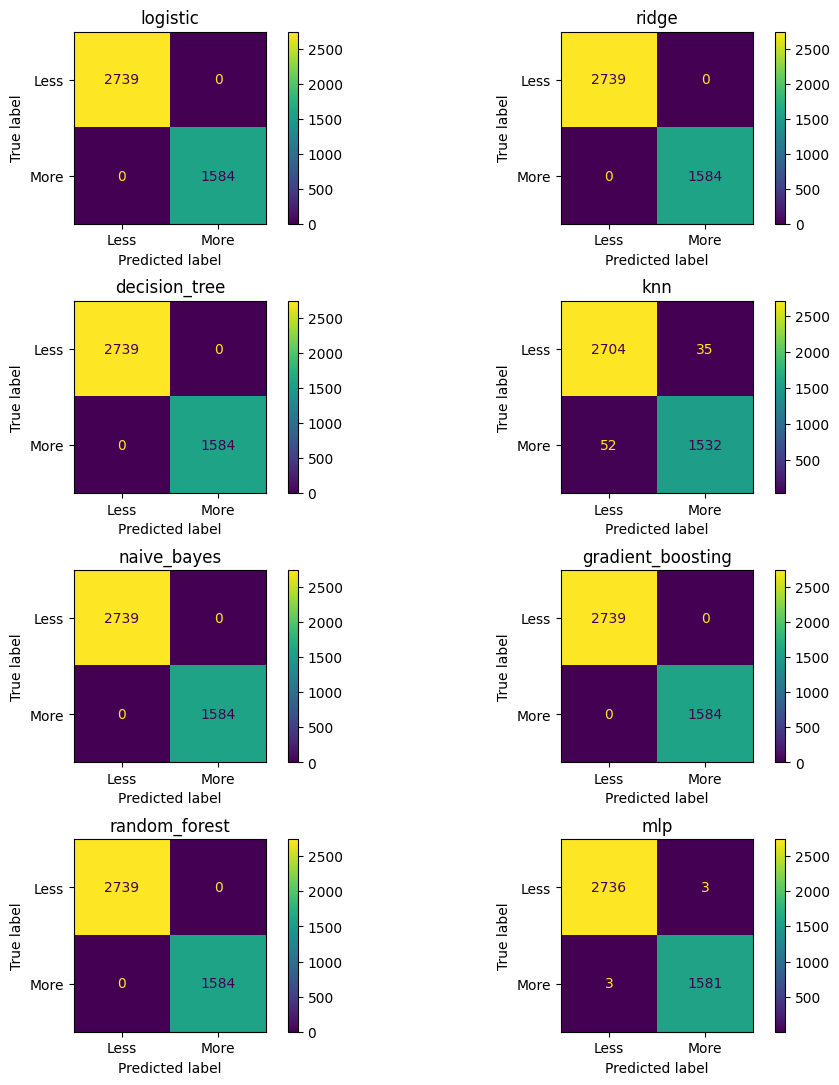

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

_, ax = plt.subplots(int(len(class_models) / 2), 2, figsize=(12, 10), sharex=False, sharey=False)
for index, key in enumerate(class_models.keys()):
    c_matrix = class_models[key]["Confusion_matrix"]
    disp = ConfusionMatrixDisplay(
        confusion_matrix=c_matrix, display_labels=["Less", "More"]
    ).plot(ax=ax.flat[index])
    disp.ax_.set_title(key)

plt.subplots_adjust(top=1, bottom=0, hspace=0.4, wspace=0.1)
plt.show()

Точность, полнота, верность (аккуратность), F-мера

In [34]:
class_metrics = pd.DataFrame.from_dict(class_models, "index")[
    [
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
        "Accuracy_train",
        "Accuracy_test",
        "F1_train",
        "F1_test",
    ]
]
class_metrics.sort_values(
    by="Accuracy_test", ascending=False
).style.background_gradient(
    cmap="plasma",
    low=0.3,
    high=1,
    subset=["Accuracy_train", "Accuracy_test", "F1_train", "F1_test"],
).background_gradient(
    cmap="viridis",
    low=1,
    high=0.3,
    subset=[
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
    ],
)

ROC-кривая, каппа Коэна, коэффициент корреляции Мэтьюса

In [35]:
class_metrics = pd.DataFrame.from_dict(class_models, "index")[
    [
        "Accuracy_test",
        "F1_test",
        "ROC_AUC_test",
        "Cohen_kappa_test",
        "MCC_test",
    ]
]
class_metrics.sort_values(by="ROC_AUC_test", ascending=False).style.background_gradient(
    cmap="plasma",
    low=0.3,
    high=1,
    subset=[
        "ROC_AUC_test",
        "MCC_test",
        "Cohen_kappa_test",
    ],
).background_gradient(
    cmap="viridis",
    low=1,
    high=0.3,
    subset=[
        "Accuracy_test",
        "F1_test",
    ],
)

In [36]:
best_model = str(class_metrics.sort_values(by="MCC_test", ascending=False).iloc[0].name)

display(best_model)

'logistic'

#### Вывод данных с ошибкой предсказания для оценки

In [37]:
preprocessing_result = pipeline_end.transform(X_test)
preprocessed_df = pd.DataFrame(
    preprocessing_result,
    columns=pipeline_end.get_feature_names_out(),
)

y_pred = class_models[best_model]["preds"]

# Cравнение реальных значений (y_test["above_average_price"]) с предсказанными значениями (y_pred)
# на тестовых данных
error_index = y_test[y_test["above_average_price"] != y_pred].index.tolist()
display(f"Error items count: {len(error_index)}")

error_predicted = pd.Series(y_pred, index=y_test.index).loc[error_index]
error_df = X_test.loc[error_index].copy()
error_df.insert(loc=1, column="Predicted", value=error_predicted)
error_df.sort_index()

'Error items count: 0'

Empty DataFrame
Columns: [price, Predicted, bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, grade, sqft_above, sqft_basement, yr_built, yr_renovated, zipcode, lat, long, sqft_living15, sqft_lot15, date_numeric, above_average_price]
Index: []

[0 rows x 22 columns]

#### Пример использования обученной модели (конвейера) для предсказания

In [41]:
model = class_models[best_model]["pipeline"]

example_id = 626059335
test = pd.DataFrame(X_test.loc[example_id, :]).T
test_preprocessed = pd.DataFrame(preprocessed_df.loc[example_id, :]).T
display(test)
display(test_preprocessed)
result_proba = model.predict_proba(test)[0]
result = model.predict(test)[0]
real = int(y_test.loc[example_id].values[0])
display(f"predicted: {result} (proba: {result_proba})")
display(f"real: {real}")

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
626059335  527000.0       4.0       2.25       2330.0   19436.0     2.0   

           waterfront  view  condition  grade  ...  sqft_basement  yr_built  \
626059335         0.0   0.0        3.0    8.0  ...            0.0    1987.0   

           yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  \
626059335           0.0  98011.0  47.7663 -122.215         1910.0     10055.0   

           date_numeric  above_average_price  
626059335       16317.0                  0.0  

[1 rows x 21 columns]

preprocessing_num__price  preprocessing_num__bedrooms  \
626059335                 -0.034693                       0.6975   

           preprocessing_num__bathrooms  preprocessing_num__sqft_living  \
626059335                      0.172229                        0.275457   

           preprocessing_num__sqft_lot  preprocessing_num__floors  \
626059335                     0.108187                   0.939548   

           preprocessing_num__waterfront  preprocessing_num__view  \
626059335                      -0.087375                -0.307461   

           preprocessing_num__condition  preprocessing_num__grade  ...  \
626059335                     -0.630265                  0.293371  ...   

           preprocessing_num__sqft_basement  preprocessing_num__yr_built  \
626059335                          -0.66087                     0.541943   

           preprocessing_num__yr_renovated  preprocessing_num__zipcode  \
626059335                        -0.208897                   -1.248545   

           preprocessing_num__lat  preprocessing_num__long  \
626059335                1.491739                 -0.00418   

           preprocessing_num__sqft_living15  preprocessing_num__sqft_lot15  \
626059335                         -0.112556                      -0.091828   

           preprocessing_num__date_numeric  remainder__above_average_price  
626059335                        -0.485795                             0.0  

[1 rows x 21 columns]

'predicted: 0 (proba: [0.99455988 0.00544012])'

'real: 0'

#### Подбор гиперпараметров методом поиска по сетке

In [42]:
from sklearn.model_selection import GridSearchCV

optimized_model_type = "random_forest"

random_forest_model = class_models[optimized_model_type]["pipeline"]

param_grid = {
    "model__n_estimators": [10, 20, 30, 40, 50, 100, 150, 200, 250, 500],
    "model__max_features": ["sqrt", "log2", 2],
    "model__max_depth": [2, 3, 4, 5, 6, 7, 8, 9 ,10],
    "model__criterion": ["gini", "entropy", "log_loss"],
}

gs_optomizer = GridSearchCV(
    estimator=random_forest_model, param_grid=param_grid, n_jobs=-1
)
gs_optomizer.fit(X_train, y_train.values.ravel())
gs_optomizer.best_params_

c:\TEMP_UNIVERSITY\mai\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'model__criterion': 'gini',
 'model__max_depth': 2,
 'model__max_features': 'sqrt',
 'model__n_estimators': 10}

Обучение модели с новыми гиперпараметрами

In [43]:
optimized_model = ensemble.RandomForestClassifier(
    random_state=random_state,
    criterion="gini",
    max_depth=7,
    max_features="sqrt",
    n_estimators=30,
)

result = {}

result["pipeline"] = Pipeline([("pipeline", pipeline_end), ("model", optimized_model)]).fit(X_train, y_train.values.ravel())
result["train_preds"] = result["pipeline"].predict(X_train)
result["probs"] = result["pipeline"].predict_proba(X_test)[:, 1]
result["preds"] = np.where(result["probs"] > 0.5, 1, 0)

result["Precision_train"] = metrics.precision_score(y_train, result["train_preds"])
result["Precision_test"] = metrics.precision_score(y_test, result["preds"])
result["Recall_train"] = metrics.recall_score(y_train, result["train_preds"])
result["Recall_test"] = metrics.recall_score(y_test, result["preds"])
result["Accuracy_train"] = metrics.accuracy_score(y_train, result["train_preds"])
result["Accuracy_test"] = metrics.accuracy_score(y_test, result["preds"])
result["ROC_AUC_test"] = metrics.roc_auc_score(y_test, result["probs"])
result["F1_train"] = metrics.f1_score(y_train, result["train_preds"])
result["F1_test"] = metrics.f1_score(y_test, result["preds"])
result["MCC_test"] = metrics.matthews_corrcoef(y_test, result["preds"])
result["Cohen_kappa_test"] = metrics.cohen_kappa_score(y_test, result["preds"])
result["Confusion_matrix"] = metrics.confusion_matrix(y_test, result["preds"])

Формирование данных для оценки старой и новой версии модели

In [44]:
optimized_metrics = pd.DataFrame(columns=list(result.keys()))
optimized_metrics.loc[len(optimized_metrics)] = pd.Series(
    data=class_models[optimized_model_type]
)
optimized_metrics.loc[len(optimized_metrics)] = pd.Series(
    data=result
)
optimized_metrics.insert(loc=0, column="Name", value=["Old", "New"])
optimized_metrics = optimized_metrics.set_index("Name")

Оценка параметров старой и новой модели

In [45]:
optimized_metrics[
    [
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
        "Accuracy_train",
        "Accuracy_test",
        "F1_train",
        "F1_test",
    ]
].style.background_gradient(
    cmap="plasma",
    low=0.3,
    high=1,
    subset=["Accuracy_train", "Accuracy_test", "F1_train", "F1_test"],
).background_gradient(
    cmap="viridis",
    low=1,
    high=0.3,
    subset=[
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
    ],
)

In [46]:
optimized_metrics[
    [
        "Accuracy_test",
        "F1_test",
        "ROC_AUC_test",
        "Cohen_kappa_test",
        "MCC_test",
    ]
].style.background_gradient(
    cmap="plasma",
    low=0.3,
    high=1,
    subset=[
        "ROC_AUC_test",
        "MCC_test",
        "Cohen_kappa_test",
    ],
).background_gradient(
    cmap="viridis",
    low=1,
    high=0.3,
    subset=[
        "Accuracy_test",
        "F1_test",
    ],
)

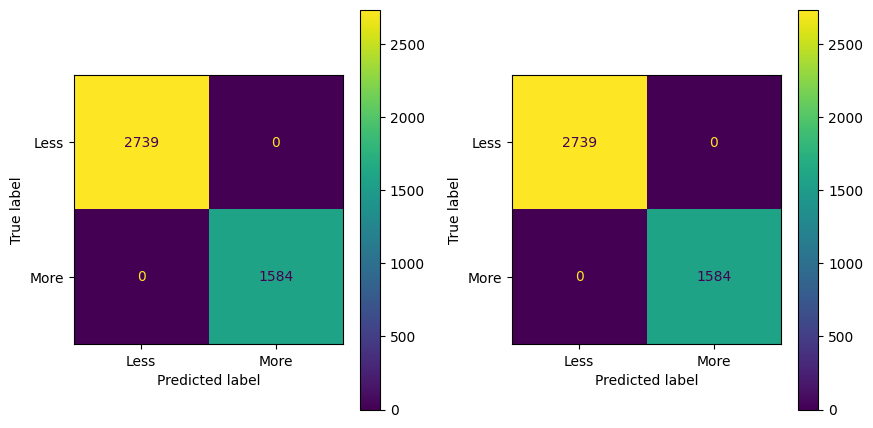

In [47]:
_, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=False, sharey=False
)

for index in range(0, len(optimized_metrics)):
    c_matrix = optimized_metrics.iloc[index]["Confusion_matrix"]
    disp = ConfusionMatrixDisplay(
        confusion_matrix=c_matrix, display_labels=["Less", "More"]
    ).plot(ax=ax.flat[index])

plt.subplots_adjust(top=1, bottom=0, hspace=0.4, wspace=0.3)
plt.show()